# Decision Analysis

In [1]:
from utils import set_pyplot_params
set_pyplot_params()

- This discussion presents a problem inspired by the game show *The Price is Right*.

- It demonstrates Bayesian [decision analysis](https://en.wikipedia.org/wiki/Decision_analysis).

- As in previous examples, we'll use data and prior distribution to compute a posterior distribution; then we'll use the posterior distribution to choose an optimal strategy, i.e. make a decision, in a game that involves bidding.

- As part of the solution, we will use kernel density estimation (KDE) to estimate the prior distribution, and a normal distribution to compute the likelihood of the data.

## The Price Is Right Problem


<img src="../figs/price-is-right-wheel-1170x780.jpg" alt="Alternative Text" width="500"/>

- On November 1, 2007, contestants named Letia and Nathaniel appeared on *The Price is Right*, an American television game show. 

- They competed in a game called "The Showcase", where the objective is to guess the price of a collection of prizes. 

- The contestant who comes closest to the actual price, without going over, wins the prizes.

- Nathaniel went first. His showcase included a dishwasher, a wine cabinet, a laptop computer, and a car. He bid \\$26,000.

- Letia's showcase included a pinball machine, a video arcade game, a pool table, and a cruise of the Bahamas. She bid \\$21,500.

- The actual price of Nathaniel's showcase was \\$25,347. His bid was too high, so he lost.

- The actual price of Letia's showcase was \\$21,578. 

- She was only off by \\$78, so she won her showcase and, because her bid was off by less than 250, she also won Nathaniel's showcase.

For a Bayesian thinker, this scenario suggests several questions:

1. Before seeing the prizes, what prior beliefs should the contestants have about the price of the showcase?

2. After seeing the prizes, how should the contestants update those beliefs?

3. Based on the posterior distribution, what should the contestants bid?

The third question demonstrates a common use of Bayesian methods: **decision analysis**.

## The Prior

- To choose a prior distribution of prices, we can take advantage of data from previous episodes. Fortunately, [fans of the show keep detailed records](https://web.archive.org/web/20121107204942/http://www.tpirsummaries.8m.com/). 

- For this example, we will use the files containing the price of each showcase from the 2011 and 2012 seasons and the bids offered by the contestants.

The following function reads the data and cleans it up a little.

In [3]:
import pandas as pd

def read_data(filename):
    '''Read the showcase price data.'''
    df = pd.read_csv(filename, index_col=0, skiprows=[1])
    return df.dropna().transpose()

I'll read both files and concatenate them.

In [4]:
df2011 = read_data('../data/showcases.2011.csv')
df2012 = read_data('../data/showcases.2012.csv')

df = pd.concat([df2011, df2012], ignore_index=True)

In [5]:
print(df2011.shape, df2012.shape, df.shape)

(191, 6) (122, 6) (313, 6)


Here's what the dataset looks like:

In [6]:
df.head(3)

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
0,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
1,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
2,32815.0,53186.0,32000.0,45000.0,815.0,8186.0


- The first two columns, `Showcase 1` and `Showcase 2`, are the values of the showcases in dollars.

- The next two columns are the bids the contestants made.

- The last two columns are the differences between the actual values and the bids.

## Kernel Density Estimation

- This dataset contains the prices for 313 previous showcases, which we can think of as a sample from the population of possible prices.

- We can use this sample to estimate the prior distribution of showcase prices.  

- One way to do that is kernel density estimation (KDE), which uses the sample to estimate a smooth distribution.  

- You can read about KDEs here: (https://mathisonian.github.io/kde).

- SciPy provides `gaussian_kde`, which takes a sample and returns an object that represents the estimated distribution.

- The following function takes `sample`, makes a KDE, evaluates it at a given sequence of quantities, `qs`, and returns the result as a normalized PMF.

In [8]:
from scipy.stats import gaussian_kde
from empiricaldist import Pmf

def kde_from_sample(sample, qs):
    '''Make a kernel density estimate from a sample'''
    kde = gaussian_kde(sample)
    ps = kde(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

We can use it to estimate the distribution of values for Showcase 1:

In [9]:
import numpy as np

qs = np.linspace(0, 80000, 81)
prior1 = kde_from_sample(df['Showcase 1'], qs)

Here's what it looks like:

In [10]:
from utils import decorate

def decorate_value(title=''):
    decorate(xlabel='Showcase value ($)',
            ylabel='PMF',
            title=title)

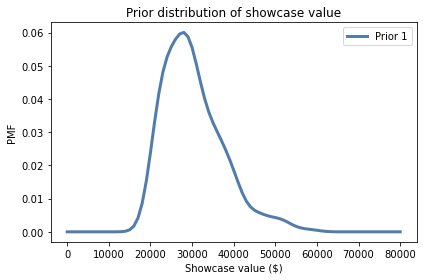

In [11]:
prior1.plot(label='Prior 1')
decorate_value('Prior distribution of showcase value')

**Exercise:** Use this function to make a `Pmf` that represents the prior distribution for Showcase 2, and plot it.

In [13]:
qs = np.linspace(0, 80000, 81)
prior2 = kde_from_sample(df['Showcase 2'], qs)

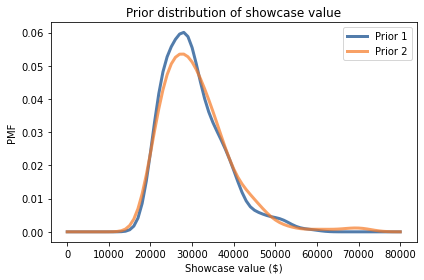

In [14]:
prior1.plot(label='Prior 1')
prior2.plot(label='Prior 2')
decorate_value('Prior distribution of showcase value')

## Distribution of Error

- To update these priors, we have to answer these questions:


* What data should we consider and how should we quantify it?

* Can we compute a likelihood function; that is, for each hypothetical price, can we compute the conditional likelihood of the data?

- To answer these questions, we will model each contestant as a price-guessing instrument with known error characteristics. 

- In this model, when the contestant sees the prizes, they guess the price of each prize and add up the prices.
Let's call this total `guess`.


- Now the question we have to answer is, "If the actual price is `price`, what is the likelihood that the contestant's guess would be `guess`, i.e., $P(`guess`|`price`)$?"

- Equivalently, if we define `error = guess - price`, we can ask, "What is the likelihood that the contestant's guess is off by `error`?"

- To answer this question, we'll use the historical data again. 

- For each showcase in the dataset, let's look at the difference between the contestant's bid and the actual price:

In [17]:
sample_diff1 = df['Bid 1'] - df['Showcase 1']
sample_diff2 = df['Bid 2'] - df['Showcase 2']

To visualize the distribution of these differences, we can use KDE again.

In [18]:
qs = np.linspace(-40000, 20000, 61)
kde_diff1 = kde_from_sample(sample_diff1, qs)
kde_diff2 = kde_from_sample(sample_diff2, qs)

Here's what these distributions look like:

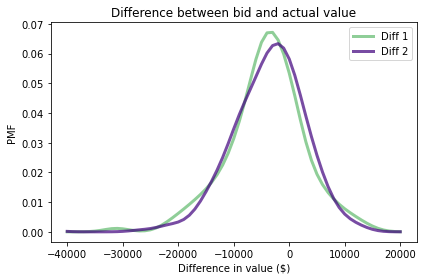

In [20]:
kde_diff1.plot(label='Diff 1', color='C8')
kde_diff2.plot(label='Diff 2', color='C4')

decorate(xlabel='Difference in value ($)',
        ylabel='PMF',
        title='Difference between bid and actual value')

- It looks like the bids are too low more often than too high, which makes sense.  Remember that under the rules of the game, you lose if you overbid, so contestants probably underbid a little deliberately.

- For example, if they guess that the value of the showcase is \\$40,000, they might bid \\$36,000 to avoid going over.

- It looks like these distributions are well modeled by a normal distribution, so we can summarize them with their mean and standard deviation.

- For example, here is the mean and standard deviation of `Diff` for Player 1.

- Now we can use these differences to model the contestant's distribution of errors.

- This step is a little tricky because we don't actually know the contestant's guesses; we only know their bids.


- So we have to make some assumptions:


* Let's assume that contestants underbid because they are being strategic, and that on average their guesses are accurate.  In other words, the mean of their errors is 0.

* But let's also assume that the spread of the differences reflects the actual spread of their errors.  So, we'll use the standard deviation of the differences as the standard deviation of their errors.


- Based on these assumptions, we'll make a normal distribution with parameters 0 and `std_diff1`.

- SciPy provides an object called `norm` that represents a normal distribution with the given mean and standard deviation.

- The result is an object that provides `pdf`, which evaluates the probability density function of the normal distribution.


- For example, here is the probability density of `error=-100`, based on the distribution of errors for Player 1.

- By itself, this number doesn't mean much, because probability densities are not probabilities. 

- But they are proportional to probabilities, so we can use them as likelihoods in a Bayesian update, as we'll see in the next section.

## Update

- Suppose you are Player 1.  

- You see the prizes in your showcase and your guess for the total price is \\$23,000.


- From your guess we will subtract away each hypothetical price in the prior distribution; the result is your error under each hypothesis.

- Now suppose we know, based on past performance, that your estimation error is well modeled by `error_dist1`.

- Under that assumption we can compute the likelihood of your error under each hypothesis.

The result is an array of likelihoods, which we can use to update the prior.

Here's what the posterior distribution looks like:

- Because your initial guess (\\$23,000) is in the lower end of the range of the prior, the posterior distribution has shifted to the left. 


- We can compute the posterior mean to see by how much.

- Before you saw the prizes, you expected to see a showcase with a value close to \\$30,000.

- After making a guess of \\$23,000, you updated the prior distribution.

- Based on the combination of the prior and your guess, you now expect the actual price to be about \\$26,000.

**Exercise:** Now suppose you are Player 2.  When you see your showcase, you guess that the total price is \\$38,000.

Use `diff2` to construct a normal distribution that represents the distribution of your estimation errors.

Compute the likelihood of your guess for each actual price and use it to update `prior2`.

Plot the posterior distribution and compute the posterior mean.  Based on the prior and your guess, what do you expect the actual price of the showcase to be?

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

- Before you saw the prizes, you expected to see a showcase with a value close to \\$31,000.

- After making a guess of \\$36,000, you updated the prior distribution.

- Based on the combination of the prior and your guess, you now expect the actual price to be about \\$34,300.

## Probability of Winning

- Now that we have a posterior distribution for each player, let's think about strategy.


- First, from the point of view of Player 1, let's compute the probability that Player 2 overbids.  

- To keep it simple, we'll use only the performance of past players, ignoring the value of the showcase. 


- The following function takes a sequence of past bids and returns the fraction that overbid.

Here's an estimate for the probability that Player 2 overbids.

- Now suppose Player 1 underbids by \\$5000.

- What is the probability that Player 2 underbids by more?


- The following function uses past performance to estimate the probability that a player underbids by more than a given amount, `diff`:

Here's the probability that Player 2 underbids by more than \\$5000.

And here's the probability they underbid by more than \\$10,000.

We can combine these functions to compute the probability that Player 1 wins, given the difference between their bid and the actual price:

- Assume you you are Player 1

- Here's the probability that you win, given that you underbid by \\$5000.

Now let's look at the probability of winning for a range of possible differences.

Here's what it looks like:

- If you underbid by \\$30,000, the chance of winning is about 30%, which is mostly the chance your opponent overbids.


- As your bids gets closer to the actual price, your chance of winning approaches 1.


- And, of course, if you overbid, you lose (even if your opponent also overbids).

**Exercise:** Run the same analysis from the point of view of Player 2.  Using the sample of differences from Player 1, compute:

1. The probability that Player 1 overbids.

2. The probability that Player 1 underbids by more than \\$5000.

3. The probability that Player 2 wins, given that they underbid by \\$5000.

Then plot the probability that Player 2 wins for a range of possible differences between their bid and the actual price.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

## Decision Analysis

- In the previous section we computed the probability of winning, given that we have underbid by a particular amount.


- In reality the contestants don't know how much they have underbid by, because they don't know the actual price.


- But they do have a posterior distribution that represents their beliefs about the actual price, and they can use that to estimate their probability of winning with a given bid.


- The following function takes a possible bid, a posterior distribution of actual prices, and a sample of differences for the opponent.


- It loops through the hypothetical prices in the posterior distribution and, for each price,

1. Computes the difference between the bid and the hypothetical price,

2. Computes the probability that the player wins, given that difference, and

3. Adds up the weighted sum of the probabilities, where the weights are the probabilities in the posterior distribution. 

- This loop implements the law of total probability:


$P(win) = \sum_{price} P(price) ~ P(win ~|~ price)$


- Here's the probability that Player 1 wins, based on a bid of \\$25,000 and the posterior distribution `posterior1`.

Now we can loop through a series of possible bids and compute the probability of winning for each one.

Here are the results.

And here's the bid that maximizes Player 1's chance of winning.

- Recall that your guess was \\$23,000.

- Using your guess to compute the posterior distribution, the posterior mean is about \\$26,000.

- But the bid that maximizes your chance of winning is \\$21,000.

**Exercise:** Do the same analysis for Player 2.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

## Maximizing Expected Gain

- In the previous section we computed the bid that maximizes your chance of winning.

- And if that's your goal, the bid we computed is optimal.


- But winning isn't everything.

- Remember that if your bid is off by \\$250 or less, you win both showcases.

- So it might be a good idea to increase your bid a little: it increases the chance you overbid and lose, but it also increases the chance of winning both showcases.


- Let's see how that works out.

- The following function computes how much you will win, on average, given your bid, the actual price, and a sample of errors for your opponent.

For example, if the actual price is \\$35000 
and you bid \\$30000, 
you will win about \\$23,600 worth of prizes on average, taking into account your probability of losing, winning one showcase, or winning both.

- In reality we don't know the actual price, but we have a posterior distribution that represents what we know about it.

- By averaging over the prices and probabilities in the posterior distribution, we can compute the expected gain for a particular bid.


- In this context, "expected" means the average over the possible showcase values, weighted by their probabilities, i.e,, their expected value.

For the posterior we computed earlier, based on a guess of \\$23,000, the expected gain for a bid of \\$21,000 is about \\$16,900.

But can we do any better? 

To find out, we can loop through a range of bids and find the one that maximizes expected gain.

Here are the results.

Here is the optimal bid.

With that bid, the expected gain is about \\$17,400.

Recall that your initial guess was \\$23,000.
The bid that maximizes the chance of winning is \\$21,000.
And the bid that maximizes your expected gain is \\$22,000.

**Exercise:** Do the same analysis for Player 2.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

## Summary

We have discussed a lot of stuff, so let's review the steps:

1. First we used KDE and data from past shows to estimate prior distributions for the values of the showcases.

2. Then we used bids from past shows to model the distribution of errors as a normal distribution.

3. We did a Bayesian update using the distribution of errors to compute the likelihood of the data.

4. We used the posterior distribution for the value of the showcase to compute the probability of winning for each possible bid, and identified the bid that maximizes the chance of winning.

5. Finally, we used probability of winning to compute the expected gain for each possible bid, and identified the bid that maximizes expected gain.

- Incidentally, this example demonstrates the hazard of using the word "optimal" without specifying what you are optimizing.

- The bid that maximizes the chance of winning is not generally the same as the bid that maximizes expected gain.

## Discussion

When people discuss the pros and cons of Bayesian estimation, as contrasted with classical methods sometimes called "frequentist", they often claim that in many cases Bayesian methods and frequentist methods produce the same results.

I would argue that this claim is mistaken because Bayesian and frequentist method produce different *kinds* of results:

* The result of frequentist methods is usually a single value that is considered to be the best estimate (by one of several criteria) or an interval that quantifies the precision of the estimate.

* The result of Bayesian methods is a posterior distribution that represents all possible outcomes and their probabilities.

- Now, you can use the posterior distribution to choose a "best" estimate or compute an interval.

- And in that case the result might be the same as the frequentist estimate.


- But doing so discards useful information and, I would argue, eliminates the primary benefit of Bayesian methods: the posterior distribution is more useful than a single estimate, or even an interval.

- The example we have discussed here demonstrates the point.

- Using the entire posterior distribution, we can compute the bid that maximizes the probability of winning, or the bid that maximizes expected gain, even if the rules for computing the gain are complicated (and nonlinear).


- With a single estimate or an interval, we can't do that, even if they are "optimal" in some sense.

- In general, frequentist estimation provides little guidance for decision-making.


- If you hear someone say that Bayesian and frequentist methods produce the same results, you can be confident that they don't understand Bayesian methods.

Now it's your turn.  Choose a prior that you think is reasonable, update it with the data you are given, and then use the posterior distribution to do the analysis I just demonstrated.

# The End